### imports

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.vision import *
from fastai.vision.interpret import *
import fastai; fastai.__version__

'1.0.55.dev0'

In [3]:
data_path = Path("../../data/siim_acr_pneu/"); data_path.ls()

[PosixPath('../../data/siim_acr_pneu/train'),
 PosixPath('../../data/siim_acr_pneu/clas_df.csv'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-test'),
 PosixPath('../../data/siim_acr_pneu/models'),
 PosixPath('../../data/siim_acr_pneu/dicom-images-train'),
 PosixPath('../../data/siim_acr_pneu/train-rle.csv'),
 PosixPath('../../data/siim_acr_pneu/seg_df.csv'),
 PosixPath('../../data/siim_acr_pneu/learn'),
 PosixPath('../../data/siim_acr_pneu/test')]

In [4]:
torch.cuda.set_device(7)

### Workflow

- 1) Run segmentation on all valid and test images
- 2) Run classification on all test valid and images
- 3) Find optimal thresh
- 4) Submit

In [5]:
# this is needed or div=False
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)

class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

In [6]:
sz = 224

In [7]:
clas_learn = Learner(**torch.load(data_path/f'learn/clas-chexpert-ft-resnet34-{sz}'))
seg_learn = Learner(**torch.load(data_path/f'learn/seg-chexpert-ft-resnext34-{sz}'))

### 1) Run seg on valid/test

In [8]:
seg_valid_probs, seg_valid_targs = seg_learn.get_preds(DatasetType.Valid)
seg_test_probs, seg_test_targs = seg_learn.get_preds(DatasetType.Test)

In [9]:
def dice_thres(input, target, t):
    "dice score with threshold"
    input_hard = input[:,1,:,:] > t
    n = input_hard.shape[0]
    inputs = input_hard.float().view(n,-1)
    targs = target.float().view(n,-1)
    intersect = (inputs * targs).sum()
    union = (inputs+targs).sum()
    dice = ((2. * intersect) / union)
    return dice

In [10]:
# dice scores at different probability thresholds
for t in np.linspace(0,1,21):
    d = dice_thres(seg_valid_probs, seg_valid_targs, t=t)
    print(t, d)

0.0 tensor(0.0289)
0.05 tensor(0.4260)
0.1 tensor(0.4927)
0.15000000000000002 tensor(0.5240)
0.2 tensor(0.5377)
0.25 tensor(0.5411)
0.30000000000000004 tensor(0.5364)
0.35000000000000003 tensor(0.5251)
0.4 tensor(0.5071)
0.45 tensor(0.4817)
0.5 tensor(0.4515)
0.55 tensor(0.4183)
0.6000000000000001 tensor(0.3845)
0.65 tensor(0.3515)
0.7000000000000001 tensor(0.3188)
0.75 tensor(0.2833)
0.8 tensor(0.2401)
0.8500000000000001 tensor(0.1891)
0.9 tensor(0.1287)
0.9500000000000001 tensor(0.0641)
1.0 tensor(0.)


### 2) Run clas on valid/test

In [11]:
from sklearn.metrics import confusion_matrix

In [12]:
clas_valid_probs, clas_valid_targs = clas_learn.get_preds(DatasetType.Valid)
clas_test_probs, clas_test_targs = clas_learn.get_preds(DatasetType.Test)

### 3) Grid search for best thres -  Calculate approx LB score 

In [13]:
from tqdm import tqdm_notebook

In [14]:
cand = []
for i in np.linspace(0,1,21):
    for j in np.linspace(0,1,21):
        cand.append((i,j))

In [15]:
def find_best_thres(cand=cand):
    "grid search cls_thres, seg_thres"
    best_score, best_seg_thres, best_cls_thres = 0, None, None
    
    for cls_thres, seg_thres in tqdm_notebook(cand):
        clas_valid_hard = clas_valid_probs[:, 1] > cls_thres
        cm = confusion_matrix(clas_valid_targs, clas_valid_hard)

        P_0_0 = cm[0,0] / cm[0, :].sum()
        P_1_1 = cm[1,1] / cm[1, :].sum()

        # public LB ratios
        R_1, R_0 = 0.7886, 0.2114
        dice_score = dice_thres(seg_valid_probs, seg_valid_targs, seg_thres)

        score_cls = R_1*P_1_1
        score_seg = R_0*P_0_0*dice_score
        total = score_cls + score_seg

        # update
        if total > best_score:
            best_score = total
            best_seg_thres = seg_thres
            best_cls_thres = cls_thres

    return best_score, best_cls_thres, best_seg_thres

In [16]:
best_score, best_cls_thres, best_seg_thres = find_best_thres()

In [17]:
best_score, best_cls_thres, best_seg_thres

(tensor(0.8345), 0.15000000000000002, 0.25)

### 4) Submit

- Convert segmentation probas to binary 
- Resize to 1024, 1024
- Separate instances
- Convert individual masks to rle

In [18]:
cls_thres, seg_thres = best_cls_thres, best_seg_thres

In [19]:
from mask_functions import *
from skimage.measure import label

In [20]:
# convert all soft mask predictions to hard predictions
seg_test_hard = (seg_test_probs[:,1,:,:] > seg_thres).squeeze(1); seg_test_hard.shape

torch.Size([1377, 224, 224])

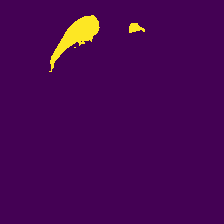

In [21]:
ImageSegment(seg_test_hard[4][None,:])

In [22]:
def tensor2pil(t):
    return (PIL.Image.fromarray((to_np(t)*255).astype(np.uint8), mode='L')
                .resize((1024,1024), PIL.Image.NEAREST))

In [23]:
def maskarray2rles(maskarray):
    rles = []
    labeled_maskarray = label(maskarray)
    unique_labels = list(np.unique(labeled_maskarray)[1:])
    for l in unique_labels:
        rle = mask2rle((labeled_maskarray == l).astype(np.uint8)*255, *(1024,1024))
        rles.append(rle)
    return rles

In [24]:
# extract test image ids
test_image_ids = np.array([o.stem for o in seg_learn.data.test_ds.items])

In [25]:
# find images to submit mask predictions for
has_pneumo = to_np((clas_test_probs[:, 1] < cls_thres)).astype(bool)

mask_test_image_ids = test_image_ids[has_pneumo]
mask_test_hard = seg_test_hard[tensor(has_pneumo)]

no_mask_test_image_ids = test_image_ids[~has_pneumo]

In [26]:
mask_test_image_ids.shape, no_mask_test_image_ids.shape, mask_test_hard.shape

((150,), (1227,), torch.Size([150, 224, 224]))

In [27]:
# create rle for all test predictions
all_image_ids = []
all_rles = []
for i in tqdm_notebook(range(len(mask_test_image_ids))):    
    image_id, t = mask_test_image_ids[i], mask_test_hard[i]
    maskimg = tensor2pil(t)
    maskarray = np.asarray(maskimg).T
    if len(np.unique(maskarray)) != 1: rles = maskarray2rles(maskarray)
    else: rles = ['-1']
    for rle in rles:
        all_image_ids.append(image_id)
        all_rles.append(rle)

In [28]:
len(all_image_ids), len(all_rles)

(339, 339)

In [29]:
sub1 = pd.DataFrame({"ImageId": all_image_ids, "EncodedPixels":all_rles})
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

final_sub = pd.concat([sub1, sub2])
final_sub.to_csv("sub.csv", index=False)

In [30]:
sub2 = pd.DataFrame({"ImageId": no_mask_test_image_ids, "EncodedPixels":"-1"})

In [31]:
final_sub = pd.concat([sub1, sub2])

In [32]:
final_sub.to_csv("sub.csv", index=False)

In [33]:
from IPython.display import FileLink

In [34]:
FileLink("sub.csv")

/home/turgutluk/git/siim_acr_pneu/sub.csv